# Previsão temporal - preços da bolsa de valores

## Importando bibliotecas

In [1]:
# Importacao desta lib para desativar erro no TensorFlow
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

2025-01-15 16:35:51.783788: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 16:35:51.787831: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 16:35:51.841805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 16:35:52.964029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
np.__version__, pd.__version__, tf.__version__, matplotlib.__version__, sklearn.__version__

('1.26.4', '2.2.2', '2.16.1', '3.8.4', '1.4.2')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Carregamento base de dados

In [5]:
base = pd.read_csv('petr4-treinamento.csv')
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


## Verificar se há dados faltantes na base de dados

In [6]:
base.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [7]:
base = base.dropna()

In [8]:
base.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
base.shape

(1242, 7)

In [10]:
base_treinamento = base.iloc[:,1:7].values

In [11]:
base_treinamento

array([[1.9990000e+01, 2.0209999e+01, 1.9690001e+01, 1.9690001e+01,
        1.8086271e+01, 3.0182600e+07],
       [1.9809999e+01, 2.0400000e+01, 1.9700001e+01, 2.0400000e+01,
        1.8738441e+01, 3.0552600e+07],
       [2.0330000e+01, 2.0620001e+01, 2.0170000e+01, 2.0430000e+01,
        1.8766001e+01, 3.6141000e+07],
       ...,
       [1.5990000e+01, 1.6139999e+01, 1.5980000e+01, 1.6049999e+01,
        1.6017963e+01, 2.3552200e+07],
       [1.6100000e+01, 1.6129999e+01, 1.6000000e+01, 1.6100000e+01,
        1.6067865e+01, 1.9011500e+07],
       [1.6100000e+01, 1.6100000e+01, 1.6100000e+01, 1.6100000e+01,
        1.6067865e+01, 0.0000000e+00]])

## Normalização dos dados - escalonamento

In [12]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

In [13]:
## Este normalizador servirá apenas para a base de teste de previsores
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

## Separacao base de previsores e alvo com base nos ultimos 90 registros

In [14]:
base_treinamento_normalizada.shape

(1242, 6)

In [15]:
X = [] # previsores
y = [] # alvo - preco real

for i in range(90,1242): # 90 precos anteriores
    X.append(base_treinamento_normalizada[i-90:i,0:6])
    y.append(base_treinamento_normalizada[i,0])
    #print(i,i-90)

X,y = np.array(X), np.array(y)

In [16]:
X[0], X.shape

(array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
         0.04318274],
        [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
         0.0437121 ],
        [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
         0.05170752],
        [0.78875969, 0.7949588 , 0.81013311, 0.77996075, 0.70144373,
         0.04015963],
        [0.77083338, 0.77363063, 0.78505624, 0.75147351, 0.67522435,
         0.0416214 ],
        [0.74806197, 0.75618037, 0.78505624, 0.76031438, 0.68336137,
         0.03485382],
        [0.75436047, 0.76490543, 0.78915051, 0.76768177, 0.69014234,
         0.02507502],
        [0.75823643, 0.76442079, 0.79733884, 0.77013751, 0.6924025 ,
         0.0260728 ],
        [0.76598837, 0.77411537, 0.79682707, 0.76227897, 0.68516964,
         0.0404927 ],
        [0.76598837, 0.77411537, 0.79682707, 0.76719061, 0.68969016,
         0.0423977 ],
        [0.76017437, 0.75714973, 0.79222108, 0.76817293, 0.69059437,
         0.02401858],

## Estrutura da Rede Neural

In [17]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences=True, input_shape=(X.shape[1],6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1,activation='linear'))

regressor.summary()

/home/lucas/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,451 (443.17 KB)

 Trainable params: 113,451 (443.17 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
regressor.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_absolute_error'])

In [19]:
es = EarlyStopping(monitor='loss',min_delta=1e-10,patience=10,verbose=True)
rlr = ReduceLROnPlateau(monitor='loss',factor=0.2,patience=5,verbose=1)
mcp = ModelCheckpoint(filepath='pesos.keras',monitor='loss',save_best_only=True,verbose=1)

In [20]:
regressor.fit(X,y,epochs=100,batch_size=32,callbacks=[es,rlr,mcp])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0803 - mean_absolute_error: 0.2061
Epoch 1: loss improved from inf to 0.03351, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0790 - mean_absolute_error: 0.2040 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0115 - mean_absolute_error: 0.0797
Epoch 2: loss improved from 0.03351 to 0.01045, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0115 - mean_absolute_error: 0.0797 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0073 - mean_absolute_error: 0.0655
Epoch 3: loss improved from 0.01045 to 0.00745, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0073 - mean_absolute_error: 0.0655 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0068 - mean_absolute_error: 0.0639
Epoch 4: loss improved from 0.00745 to 0.00700, saving

## Previsoes com Base de Teste

In [21]:
base_teste = pd.read_csv('petr4-teste.csv')
base_teste

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [22]:
base_teste.shape

(22, 7)

In [23]:
y_teste = base_teste.iloc[:,1:2].values
y_teste

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [25]:
frames = [base,base_teste]

In [26]:
frames

[            Date       Open       High        Low      Close  Adj Close  \
 0     2013-01-02  19.990000  20.209999  19.690001  19.690001  18.086271   
 1     2013-01-03  19.809999  20.400000  19.700001  20.400000  18.738441   
 2     2013-01-04  20.330000  20.620001  20.170000  20.430000  18.766001   
 3     2013-01-07  20.480000  20.670000  19.950001  20.080000  18.444506   
 4     2013-01-08  20.110001  20.230000  19.459999  19.500000  17.911745   
 ...          ...        ...        ...        ...        ...        ...   
 1240  2017-12-25  15.750000  15.750000  15.750000  15.750000  15.718563   
 1241  2017-12-26  15.750000  15.990000  15.690000  15.970000  15.938125   
 1242  2017-12-27  15.990000  16.139999  15.980000  16.049999  16.017963   
 1243  2017-12-28  16.100000  16.129999  16.000000  16.100000  16.067865   
 1244  2017-12-29  16.100000  16.100000  16.100000  16.100000  16.067865   
 
           Volume  
 0     30182600.0  
 1     30552600.0  
 2     36141000.0  
 3    

In [27]:
base_completa = pd.concat(frames)
base_completa

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0


In [28]:
base_completa = base_completa.drop('Date',axis=1)

In [29]:
len(base_completa), len(base_teste)

(1264, 22)

In [30]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values

In [31]:
entradas

array([[1.3930000e+01, 1.4030000e+01, 1.3760000e+01, 1.3870000e+01,
        1.3842316e+01, 2.7208100e+07],
       [1.3760000e+01, 1.3850000e+01, 1.3680000e+01, 1.3850000e+01,
        1.3822356e+01, 2.7306400e+07],
       [1.3790000e+01, 1.3900000e+01, 1.3440000e+01, 1.3450000e+01,
        1.3423154e+01, 5.8871700e+07],
       [1.3530000e+01, 1.3770000e+01, 1.3470000e+01, 1.3650000e+01,
        1.3622754e+01, 8.2909400e+07],
       [1.3850000e+01, 1.4190000e+01, 1.3820000e+01, 1.4020000e+01,
        1.3992017e+01, 6.0260300e+07],
       [1.3960000e+01, 1.4180000e+01, 1.3940000e+01, 1.4170000e+01,
        1.4141717e+01, 1.8139300e+07],
       [1.4570000e+01, 1.4650000e+01, 1.4230000e+01, 1.4410000e+01,
        1.4381238e+01, 5.6476800e+07],
       [1.4650000e+01, 1.5020000e+01, 1.4510000e+01, 1.5020000e+01,
        1.4990021e+01, 6.8418200e+07],
       [1.5020000e+01, 1.5020000e+01, 1.5020000e+01, 1.5020000e+01,
        1.4990021e+01, 0.0000000e+00],
       [1.5100000e+01, 1.5150000e+01,

In [32]:
entradas = normalizador.transform(entradas)

In [33]:
X_teste = []
for i in range(90,112):
    X_teste.append(entradas[i-90:i,0:6])
X_teste = np.array(X_teste)

In [34]:
X_teste.shape

(22, 90, 6)

In [35]:
previsoes = regressor.predict(X_teste)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


In [36]:
previsoes

array([[0.5759106 ],
       [0.57974267],
       [0.58554435],
       [0.5938424 ],
       [0.60290945],
       [0.6111263 ],
       [0.61759585],
       [0.6207661 ],
       [0.62192047],
       [0.62313056],
       [0.6256299 ],
       [0.63077956],
       [0.64120674],
       [0.6555438 ],
       [0.66942483],
       [0.6793901 ],
       [0.6832954 ],
       [0.68709105],
       [0.6947372 ],
       [0.7084788 ],
       [0.7258557 ],
       [0.7395624 ]], dtype=float32)

In [37]:
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [38]:
previsoes

array([[16.086796],
       [16.165888],
       [16.285635],
       [16.456907],
       [16.64405 ],
       [16.813646],
       [16.947178],
       [17.012611],
       [17.036438],
       [17.061415],
       [17.113   ],
       [17.21929 ],
       [17.434507],
       [17.730423],
       [18.016928],
       [18.22261 ],
       [18.303217],
       [18.38156 ],
       [18.539375],
       [18.823002],
       [19.181662],
       [19.464567]], dtype=float32)

In [39]:
y_teste

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [40]:
previsoes.mean()

17.497305

In [41]:
y_teste.mean()

17.87454563636364

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_teste,previsoes)

0.3917671954179242

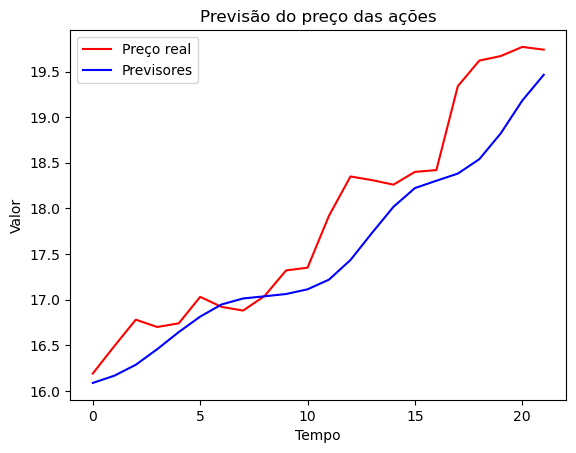

In [43]:
plt.plot(y_teste,color="red",label="Preço real")
plt.plot(previsoes,color="blue",label="Previsores")
plt.title("Previsão do preço das ações")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()